In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

sys.path.append("../..")

from drift_detector.explainer import ShiftExplainer
from drift_detector.experiments import *
from utils.constants import *
from utils.plot_utils import errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from utils.utils import *
from baseline_models.static.utils import run_model

2022-08-04 19:25:03,907 INFO cyclops.orm     - Database setup, ready to run queries!


# Config Parameters #

In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500]
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
CALC_ACC = True
TIMESTEPS = 6
AGGREGATION_TYPE = "time_flatten"
CONTEXT_TYPE="lstm"
REPRESENTATION="lstm"
SCALE=True
HOSPITAL = ["SMH","MSH","THPC","THPM","UHNTG","UHNTW","PMH"]
DR_TECHNIQUES = ["NoRed","SRP", "PCA", "kPCA", "Isomap","BBSDs_untrained_FFNN"]#["NoRed","SRP", "PCA", "kPCA", "Isomap","BBSDs_untrained_FFNN","BBSDs_untrained_LSTM", "BBSDs_trained_LSTM"]
MD_TESTS = ["Univariate","MMD", "LK", "Spot-the-diff"]

In [3]:
# ["NoRed"] --> ["MMD", "LK","Context-Aware MMD", "Spot-the-diff"]
# ["SRP", "PCA", "kPCA", "IsoMap", "BBSDs_untrained_FFNN", "BBSDs_untrained_LSTM", "BBSDs_trained_LSTM"] --> ["MMD", "LK" "Classifier" Spot-the-diff"]

# Query Data

In [4]:
admin_data, x, y = get_gemini_data(PATH)

2022-08-04 19:25:04,089 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-08-04 19:25:04,514 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-08-04 19:25:04,673 INFO cyclops.feature_handler - Loading features from file...
2022-08-04 19:25:04,675 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-04 19:25:04,678 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-04 19:25:04,712 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-08-04 19:25:09,658 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-08-04 19:25:18,039 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


# Input Parameters #

In [5]:
SHIFT = input("Select experiment: ")  # covid,seasonal,hosp_type
OUTCOME = input("Select outcome variable: ") # mortality

if SHIFT == "covid":
    EXPERIMENTS = ["pre-covid", "covid"]
    HOSPITAL= ["SMH","MSH","UHNTG","UHNTW","PMH","THPC","THPM"]
    MODEL_PATH="../../saved_models/covid_lstm.pt"

if SHIFT == "seasonal_summer":
    EXPERIMENTS = ["seasonal_summer_baseline","seasonal_summer"] 
    MODEL_PATH="../../saved_models/seasonal_summer_lstm.pt"

if SHIFT == "seasonal_winter":
    EXPERIMENTS = ["seasonal_winter_baseline","seasonal_winter"] 
    MODEL_PATH="../../saved_models/seasonal_winter_lstm.pt"
    
if SHIFT == "hosp_type_academic":
    EXPERIMENTS = ["hosp_type_academic_baseline","hosp_type_academic"]
    MODEL_PATH="../../saved_models/hosp_type_academic_lstm.pt"

if SHIFT == "hosp_type_community":
    EXPERIMENTS = ["hosp_type_community_baseline","hosp_type_community"]
    MODEL_PATH="../../saved_models/hosp_type_community_lstm.pt"

MODEL_PATH = os.path.join(os.getcwd(),MODEL_PATH)
HOSPITAL = ["SMH","MSH","THPC","THPM","UHNTG","UHNTW","PMH"]

Select experiment:  seasonal_summer
Select outcome variable:  mortality


# Drift Tests #

In [6]:
DRIFT_PATH = PATH + '_'.join(['time_flatten','ffnn','rf',SHIFT, '_'.join(HOSPITAL),''])

In [7]:
DRIFT_PATH

'/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/time_flatten_ffnn_rf_seasonal_summer_SMH_MSH_THPC_THPM_UHNTG_UHNTW_PMH_'

In [10]:
# Run shift experiments
if os.path.exists(os.path.join(DRIFT_PATH + "mean_dr_md_pval.pkl")):
    with open(os.path.join(DRIFT_PATH + "mean_dr_md_pval.pkl"), "rb") as f:
        mean_dr_md_pval = pickle.load(f)
    with open(os.path.join(DRIFT_PATH + "mean_dr_md_dist.pkl"), "rb") as f:
        mean_dr_md_dist = pickle.load(f)
else:
    mean_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    mean_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(os.path.join(DRIFT_PATH + "std_dr_md_pval.pkl")):
    with open(os.path.join(DRIFT_PATH + "std_dr_md_pval.pkl"), "rb") as f:
        std_dr_md_pval = pickle.load(f)
    with open(os.path.join(DRIFT_PATH + "std_dr_md_dist.pkl"), "rb") as f:
        std_dr_md_dist = pickle.load(f)
        
else:
    std_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    std_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)


for si, SHIFT in enumerate(EXPERIMENTS):
    for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
        for mi, MD_TEST in enumerate(MD_TESTS):
            if np.any(mean_dr_md_pval[si, di, mi, :] == -1):
                print(
                    "{} | {} | {} | {}".format(
                        SHIFT, HOSPITAL, DR_TECHNIQUE, MD_TEST
                    )
                )
                
                if AGGREGATION_TYPE == "time_flatten" and MD_TEST == "Classifier":
                    REPRESENTATION="rf"
                    CONTEXT_TYPE="ffnn"
                elif AGGREGATION_TYPE == "time_flatten" and MD_TEST == "LK":
                    REPRESENTATION="ffnn"
                    CONTEXT_TYPE="ffnn"
                elif AGGREGATION_TYPE == "time":
                    CONTEXT_TYPE="lstm"
                    REPRESENTATION="lstm"
                    
                if True:
                    mean_p_vals, std_p_vals, mean_dist, std_dist = run_shift_experiment(
                            shift=SHIFT,
                            admin_data=admin_data,
                            x=x, 
                            y=y,
                            outcome=OUTCOME,
                            hospital=HOSPITAL,
                            path=PATH,
                            aggregation_type=AGGREGATION_TYPE,
                            scale=SCALE,
                            dr_technique=DR_TECHNIQUE,
                            model_path=MODEL_PATH,
                            md_test=MD_TEST,
                            context_type=CONTEXT_TYPE,
                            representation=REPRESENTATION,
                            samples=SAMPLES,
                            dataset=DATASET,
                            sign_level=SIGN_LEVEL,
                            timesteps=TIMESTEPS,
                            random_runs=RANDOM_RUNS,
                            calc_acc=CALC_ACC
                    )

                    mean_dr_md_pval[si, di, mi, :] = mean_p_vals
                    std_dr_md_pval[si, di, mi, :] = std_p_vals
                    mean_dr_md_dist[si, di, mi, :] = mean_dist
                    std_dr_md_dist[si, di, mi, :] = std_dist


2022-08-04 21:30:04,862 INFO cyclops.feature_handler - Loading features from file...
2022-08-04 21:30:04,866 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-04 21:30:04,867 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-04 21:30:04,903 INFO cyclops.feature_handler - Found file to load for temporal features...


seasonal_summer_baseline | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW', 'PMH'] | kPCA | MMD


2022-08-04 21:30:09,791 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Shift seasonal_summer_baseline | Random Run 0 | Sample 10 | P-Value 0.1599999964237213
Shift seasonal_summer_baseline | Random Run 0 | Sample 20 | P-Value 0.20999999344348907
Shift seasonal_summer_baseline | Random Run 0 | Sample 50 | P-Value 0.1899999976158142
Shift seasonal_summer_baseline | Random Run 0 | Sample 100 | P-Value 0.0
Shift seasonal_summer_baseline | Random Run 0 | Sample 200 | P-Value 0.0
Shift seasonal_summer_baseline | Random Run 0 | Sample 500 | P-Value 0.0
Shift seasonal_summer_baseline | Random Run 1 | Sample 10 | P-Value 0.019999999552965164
Shift seasonal_summer_baseline | Random Run 1 | Sample 20 | P-Value 0.8799999952316284
Shift seasonal_summer_baseline | Random Run 1 | Sample 50 | P-Value 0.5199999809265137
Shift seasonal_summer_baseline | Random Run 1 | Sample 100 | P-Value 0.009999999776482582
Shift seasonal_summer_baseline | Random Run 1 | Sample 200 | P-Value 0.0
Shift seasonal_summer_baseline | Random Run 1 | Sample 500 | P-Value 0.0
Shift seasonal_summe

2022-08-04 21:31:46,850 INFO cyclops.feature_handler - Loading features from file...
2022-08-04 21:31:46,852 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-04 21:31:46,853 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-04 21:31:46,884 INFO cyclops.feature_handler - Found file to load for temporal features...


Shift seasonal_summer_baseline | Random Run 4 | Sample 500 | P-Value 0.0
seasonal_summer_baseline | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW', 'PMH'] | kPCA | LK


2022-08-04 21:31:51,738 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Shift seasonal_summer_baseline | Random Run 0 | Sample 10 | P-Value 0.46000000834465027
Shift seasonal_summer_baseline | Random Run 0 | Sample 20 | P-Value 0.9599999785423279
Shift seasonal_summer_baseline | Random Run 0 | Sample 50 | P-Value 0.5899999737739563
Shift seasonal_summer_baseline | Random Run 0 | Sample 100 | P-Value 0.019999999552965164
Shift seasonal_summer_baseline | Random Run 0 | Sample 200 | P-Value 0.05000000074505806
Shift seasonal_summer_baseline | Random Run 0 | Sample 500 | P-Value 0.44999998807907104
Shift seasonal_summer_baseline | Random Run 1 | Sample 10 | P-Value 0.17000000178813934
Shift seasonal_summer_baseline | Random Run 1 | Sample 20 | P-Value 0.6299999952316284
Shift seasonal_summer_baseline | Random Run 1 | Sample 50 | P-Value 0.4300000071525574
Shift seasonal_summer_baseline | Random Run 1 | Sample 100 | P-Value 0.03999999910593033
Shift seasonal_summer_baseline | Random Run 1 | Sample 200 | P-Value 0.5
Shift seasonal_summer_baseline | Random Run 1 

2022-08-04 21:35:47,404 INFO cyclops.feature_handler - Loading features from file...
2022-08-04 21:35:47,407 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-04 21:35:47,408 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-04 21:35:47,445 INFO cyclops.feature_handler - Found file to load for temporal features...


Shift seasonal_summer_baseline | Random Run 4 | Sample 500 | P-Value 0.0
seasonal_summer_baseline | ['SMH', 'MSH', 'THPC', 'THPM', 'UHNTG', 'UHNTW', 'PMH'] | kPCA | Spot-the-diff


2022-08-04 21:35:52,299 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Shift seasonal_summer_baseline | Random Run 0 | Sample 10 | P-Value 1.0
Shift seasonal_summer_baseline | Random Run 0 | Sample 20 | P-Value 0.5285714285714286
Shift seasonal_summer_baseline | Random Run 0 | Sample 50 | P-Value 0.2084372055458339
Shift seasonal_summer_baseline | Random Run 0 | Sample 100 | P-Value 0.06514979774124259
Shift seasonal_summer_baseline | Random Run 0 | Sample 200 | P-Value 0.08340073651381849
Shift seasonal_summer_baseline | Random Run 0 | Sample 500 | P-Value 1.9403695650987716e-09
Shift seasonal_summer_baseline | Random Run 1 | Sample 10 | P-Value 0.5
Shift seasonal_summer_baseline | Random Run 1 | Sample 20 | P-Value 0.4222222222222222
Shift seasonal_summer_baseline | Random Run 1 | Sample 50 | P-Value 0.45466123749270876
Shift seasonal_summer_baseline | Random Run 1 | Sample 100 | P-Value 0.24053316600591346
Shift seasonal_summer_baseline | Random Run 1 | Sample 200 | P-Value 0.005755869666883342


KeyboardInterrupt: 

Select Pre-Processing:  NoRed
Select Two-Sample Testing:  MMD
Plot:  P-Value


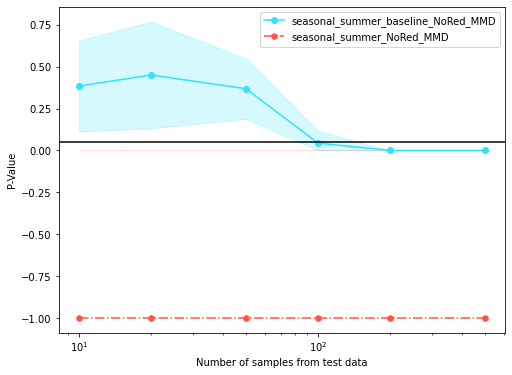

In [11]:
DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")
PLOT_METRIC = input("Plot: ")

fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(EXPERIMENTS):
    for di, dr_technique in enumerate(DR_TECHNIQUES):
        for mi, md_test in enumerate(MD_TESTS):
            if (
                    dr_technique == DIM_RED
                    and md_test == MD_TEST and 
                    PLOT_METRIC == "Distance"
            ):
                errorfill(
                        np.array(SAMPLES),
                        mean_dr_md_dist[si, di, mi, :],
                        std_dr_md_dist[si, di, mi, :],
                        fmt=linestyles[si] + markers[si],
                        color=colorscale(colors[si], brightness[si]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                )
            elif (
                    dr_technique == DIM_RED
                    and md_test == MD_TEST and 
                    PLOT_METRIC == "P-Value"
            ):
                errorfill(
                        np.array(SAMPLES),
                        mean_dr_md_pval[si, di, mi, :],
                        std_dr_md_pval[si, di, mi, :],
                        fmt=linestyles[si] + markers[si],
                        color=colorscale(colors[si], brightness[si]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test data")
plt.ylabel(PLOT_METRIC)
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()

# Run shift experiments
if not os.path.exists(os.path.join(DRIFT_PATH + "mean_dr_md_pval.pkl")):
    with open(os.path.join(DRIFT_PATH + "mean_dr_md_pval.pkl"), "wb") as f:
        pickle.dump(mean_dr_md_pval, f)
    with open(os.path.join(DRIFT_PATH + "mean_dr_md_dist.pkl"), "wb") as f:
        pickle.dump(mean_dr_md_dist, f)
if not os.path.exists(os.path.join(DRIFT_PATH + "std_dr_md_pval.pkl")):
    with open(os.path.join(DRIFT_PATH + "std_dr_md_pval.pkl"), "wb") as f:
        pickle.dump(std_dr_md_pval, f)
    with open(os.path.join(DRIFT_PATH + "std_dr_md_dist.pkl"), "wb") as f:
        pickle.dump(std_dr_md_dist, f)

# Build Model #

In [38]:
SHIFT="seasonal_winter"
scale = True

(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITAL, 1, shuffle=True)

aggregation_type = "time_flatten"
numerical_cols = get_numerical_cols(PATH)

# Normalize data
(X_tr_normalized, y_tr),(X_val_normalized, y_val), (X_t_normalized, y_t) = normalize_data(aggregation_type, admin_data, TIMESTEPS, X_tr, y_tr, X_val, y_val, X_t, y_t)

# Scale data
if scale:
    X_tr_normalized, X_val_normalized, X_t_normalized = scale_data(numerical_cols, X_tr_normalized, X_val_normalized, X_t_normalized)
# Process data
X_tr_final, X_val_final, X_t_final = process_data(aggregation_type, TIMESTEPS, X_tr_normalized, X_val_normalized, X_t_normalized)

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT, OUTCOME, aggregation_type, '_'.join(HOSPITAL), MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_tr_final, y_tr, X_val_final, y_val)
    pickle.dump(optimised_model, open(MODEL_PATH, 'wb'))

2022-08-02 22:20:48,913 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:20:48,916 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:20:48,917 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:20:48,951 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:20:53,754 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Select Model:  xgb


### Performance on Source Data ###

<AxesSubplot:title={'center':'PRC curve (area = 0.911178)'}, xlabel='Recall', ylabel='Precision'>

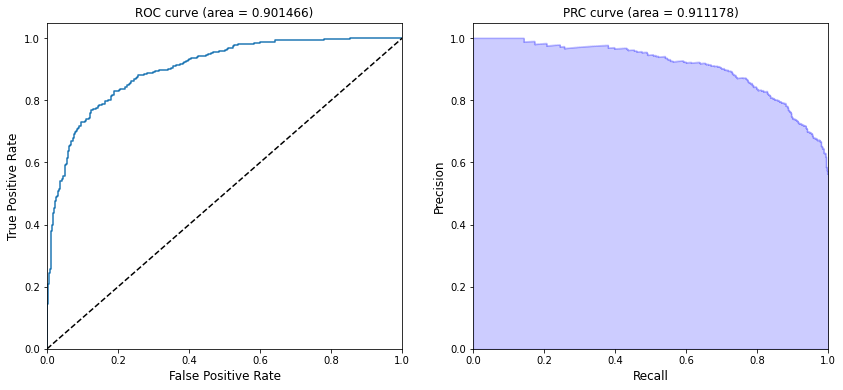

In [39]:
y_pred_prob = optimised_model.predict_proba(X_val_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
auc_pr = auc(recall, precision)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, auc_pr)

### Performance on Target Data ###

<AxesSubplot:title={'center':'PRC curve (area = 0.895006)'}, xlabel='Recall', ylabel='Precision'>

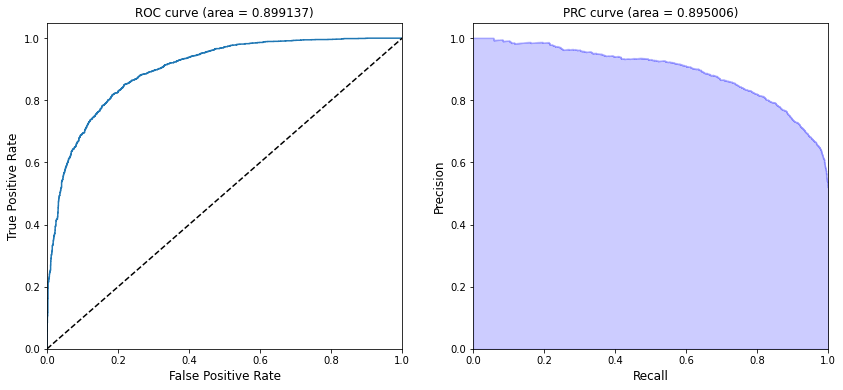

In [40]:
y_pred_prob = optimised_model.predict_proba(X_t_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_t, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_t, y_pred_prob)
auc_pr = auc(recall, precision)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, auc_pr)

In [41]:
val_auroc = [] 
val_auprc = []
test_auroc = []
test_auprc = []
RANDOM_RUNS=10
for i in range(0, RANDOM_RUNS):
    random.seed(i)
    print(i)
    (X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITAL, i, shuffle=True)

    aggregation_type = "time_flatten"
    numerical_cols = get_numerical_cols(PATH)

    # Normalize data
    (X_tr_normalized, y_tr),(X_val_normalized, y_val), (X_t_normalized, y_t) = normalize_data(aggregation_type, admin_data, TIMESTEPS, X_tr, y_tr, X_val, y_val, X_t, y_t)

    # Scale data
    if scale:
        X_tr_normalized, X_val_normalized, X_t_normalized = scale_data(numerical_cols, X_tr_normalized, X_val_normalized, X_t_normalized)
    # Process data
    X_tr_final, X_val_final, X_t_final = process_data(aggregation_type, TIMESTEPS, X_tr_normalized, X_val_normalized, X_t_normalized)
    
    y_pred_prob = optimised_model.predict_proba(X_val_final)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    val_auroc.append(roc_auc)
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall, precision)
    val_auprc.append(auc_pr)
    
    y_pred_prob = optimised_model.predict_proba(X_t_final)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_t, y_pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    test_auroc.append(roc_auc)
    precision, recall, thresholds = precision_recall_curve(y_t, y_pred_prob)
    auc_pr = auc(recall, precision)
    test_auprc.append(auc_pr)

0


2022-08-02 22:20:59,836 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:20:59,838 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:20:59,839 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:20:59,866 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:04,619 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


1


2022-08-02 22:21:05,644 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:05,646 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:05,648 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:05,677 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:10,442 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


2


2022-08-02 22:21:11,478 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:11,480 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:11,482 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:11,511 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:16,258 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


3


2022-08-02 22:21:17,306 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:17,308 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:17,310 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:17,339 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:22,017 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


4


2022-08-02 22:21:23,061 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:23,062 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:23,065 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:23,094 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:27,808 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


5


2022-08-02 22:21:28,843 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:28,845 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:28,847 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:28,876 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:33,603 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


6


2022-08-02 22:21:34,654 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:34,655 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:34,657 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:34,685 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:39,430 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


7


2022-08-02 22:21:40,479 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:40,480 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:40,483 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:40,511 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:45,234 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


8


2022-08-02 22:21:46,291 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:46,292 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:46,293 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:46,322 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:51,205 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


9


2022-08-02 22:21:52,269 INFO cyclops.feature_handler - Loading features from file...
2022-08-02 22:21:52,272 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-02 22:21:52,273 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-02 22:21:52,300 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-02 22:21:57,100 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


In [42]:
import scipy.stats as st

print(np.mean(val_auroc),st.t.interval(0.95, len(val_auroc)-1, loc=np.mean(val_auroc), scale=st.sem(val_auroc)))
print(np.mean(val_auprc),st.t.interval(0.95, len(val_auprc)-1, loc=np.mean(val_auprc), scale=st.sem(val_auprc)))
print(np.mean(test_auroc),st.t.interval(0.95, len(test_auroc)-1, loc=np.mean(test_auroc), scale=st.sem(test_auroc)))
print(np.mean(test_auprc),st.t.interval(0.95, len(test_auprc)-1, loc=np.mean(test_auprc), scale=st.sem(test_auprc)))

0.977828082529489 (0.9582969679828163, 0.9973591970761618)
0.9797629974538387 (0.9622000158543448, 0.9973259790533325)
0.8920839181316651 (0.8893362474230636, 0.8948315888402666)
0.8840371016459583 (0.8803741040649026, 0.887700099227014)


## Performance by Sample Size ##

In [106]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

RANDOM_RUNS=100
samp_metrics = np.ones((len(SAMPLES), RANDOM_RUNS, 2, 2)) * (-1)
for si, sample in enumerate(SAMPLES):
    for i in range(0, RANDOM_RUNS - 1):
        i = int(i)
        np.random.seed(i)
        X_val_shuffled, y_val_shuffled = unison_shuffled_copies(X_val_final, y_val)
        X_test_shuffled, y_test_shuffled = unison_shuffled_copies(X_t_final, y_t)

        y_val_pred_prob = optimised_model.predict_proba(X_val_shuffled[:sample])[:, 1]
        val_fpr, val_tpr, val_thresholds = roc_curve(
            y_val_shuffled[:sample], y_val_pred_prob[:sample], pos_label=1
        )
        val_roc_auc = auc(val_fpr, val_tpr)
        val_avg_pr = average_precision_score(y_val_shuffled[:sample], y_val_pred_prob[:sample])

        y_test_pred_prob = optimised_model.predict_proba(X_test_shuffled[:sample])[:, 1]
        test_fpr, test_tpr, test_thresholds = roc_curve(
            y_test_shuffled[:sample], y_test_pred_prob[:sample], pos_label=1
        )
        test_roc_auc = auc(test_fpr, test_tpr)
        test_avg_pr = average_precision_score(y_test_shuffled[:sample], y_test_pred_prob[:sample])

        samp_metrics[si, i, 0, :] = [val_roc_auc, val_avg_pr]
        samp_metrics[si, i, 1, :] = [test_roc_auc, test_avg_pr]

    mean_samp_metrics = np.mean(samp_metrics, axis=1)
    std_samp_metrics = np.std(samp_metrics, axis=1)

No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless


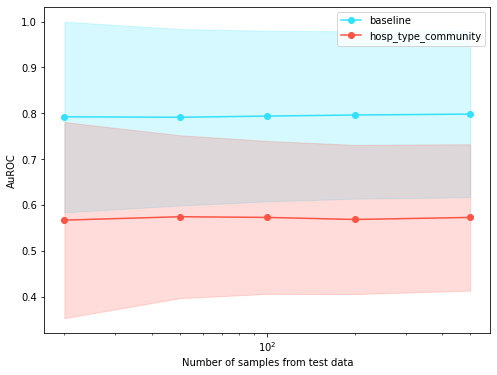

In [107]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
    for mi, metric in enumerate(["AuROC", "Avg Pr"]):
        if metric == "AuROC":
            errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, mi],
                std_samp_metrics[1:, si, mi],
                fmt=linestyles[mi] + markers[mi],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
            )
plt.xlabel("Number of samples from test data")
plt.ylabel("AuROC")
plt.legend()
plt.show()

## Explain Difference in Model Predictions ## 

In [129]:
import itertools 

timesteps = ['T1_', 'T2_','T3_','T4_', 'T5_','T6_']

flattened_feats = []
for ts in timesteps:
    flattened_feats.append(ts+feats)
flattened_feats = list(itertools.chain.from_iterable(flattened_feats))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


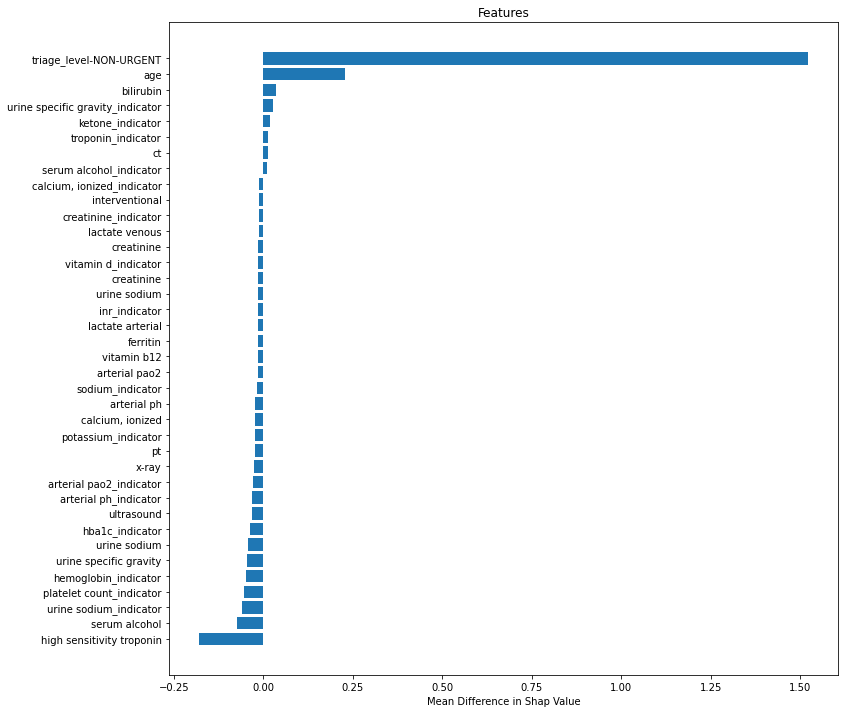

In [169]:
explainer = ShiftExplainer(optimised_model)
explainer.get_explainer()

X_val_df = pd.DataFrame(X_val_final, columns=flattened_feats)
val_shap_values = explainer.get_shap_values(X_val_df)
X_test_df = pd.DataFrame(X_t_final, columns=flattened_feats)
test_shap_values = explainer.get_shap_values(X_test_df)

diff = np.mean(np.abs(test_shap_values.values), axis=0) - np.mean(
    np.abs(val_shap_values.values), axis=0
)
diff_sorted, feats_sorted = zip(*sorted(zip(diff, flattened_feats), reverse=True))
diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(diff_sorted, feats_sorted) if (x > 0.01 or x < -0.01)))
)
diff_sorted = list(diff_sorted)
feats_sorted=list(map(lambda x: x.replace('T1_', '').replace('T2_', '').replace('T3_', '').replace('T4_', '').replace('T5_', '').replace('T6_', ''),feats_sorted))
del diff_sorted[5]
del feats_sorted[5]
fig, ax = plt.subplots(figsize=(12, 12))
y_pos = np.arange(len(diff_sorted))
ax.barh(y_pos, diff_sorted, align="center")
ax.set_yticks(y_pos, labels=feats_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Mean Difference in Shap Value")
ax.set_title("Features")
plt.show()